In [177]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numdifftools as nd
import respy as rp
import numpy as np

from calibration_maximum_likelihood import run_bootstrap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Maximum likelihood estimation

## Simulation

We first simulate a sample from one of the example models.

In [178]:
params_base, options_base, df = rp.get_example_model("robinson", with_data=True)

Let's look at the parameterization of the model and the specified options.

In [179]:
print(" Parametrization")
print(params_base)
print("\n Options")
options_base

 Parametrization
                                     value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

 Options


{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

We can study the resulting choice patterns.

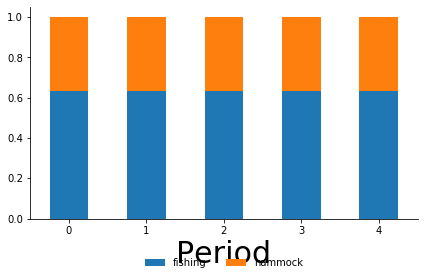

In [180]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)


plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()


## Likelihood function

We can now start exploring the likelihood function. We will first trace out the profile likelihood over reasonable parameter values.

In [186]:
params_base["lower"] = [0.9, 0.00, -0.20, 1.00, 0.0050, 0.001, -0.2]
params_base["upper"] = [1.0, 0.10,  0.00, 1.10, 0.0150, 0.030, +0.2]

# We will use estimagic and fix all parameters at their true values.
constr_base = [
    {"loc": ("shocks_sdcorr", "sd_fishing"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "sd_hammock"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "corr_hammock_fishing"), "type": "fixed"}, 
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type": "fixed"}
]

### Profile likelihood

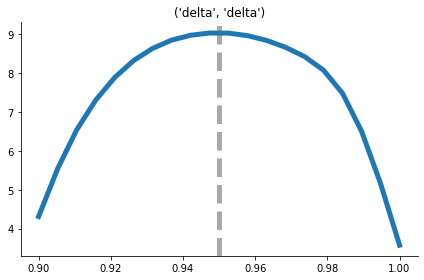

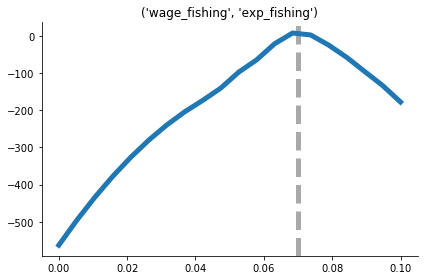

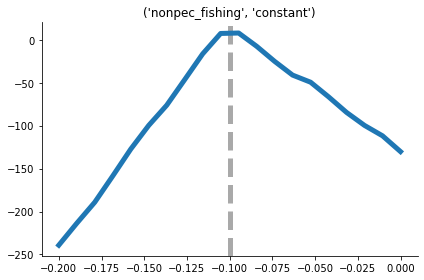

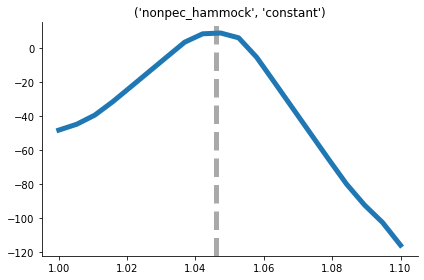

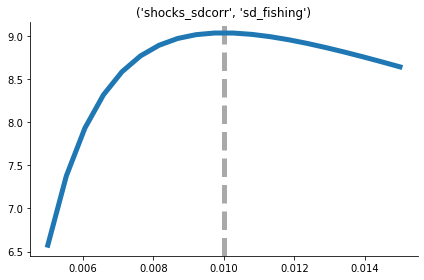

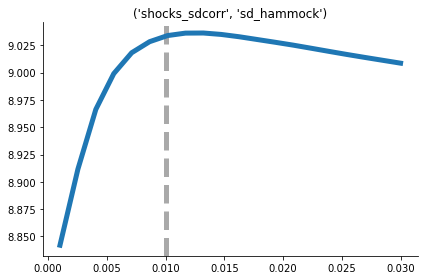

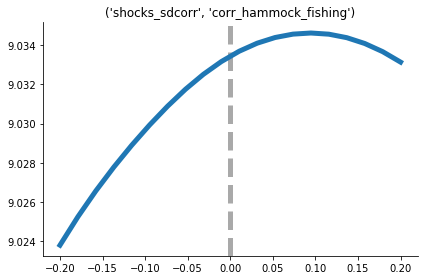

In [182]:
crit_func = rp.get_crit_func(params_base, options_base, df)

for index in params_base.index:
    upper, lower = params_base.loc[index][["upper", "lower"]]

    grid = np.linspace(lower, upper, 20)
    
    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))
    
    fig, ax = plt.subplots()

    ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--", label="Baseline")
    
    ax.plot(grid, fvals)
    ax.set_title(index)
    plt.show()

/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],
/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


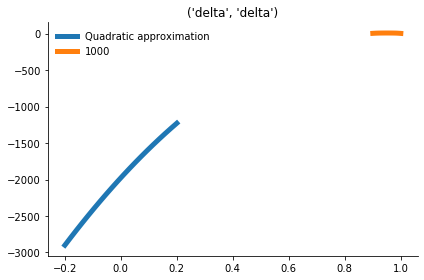

In [183]:
def evaluate_approximation(intercept, fdd, deltas):
    
    if not isinstance(deltas, list):
        deltas = [deltas]
    
    fvals = list()
    for delta in deltas:
        fvals.append(intercept + fdd * delta**2)
    
    return fvals

def wrapper_crit_func(crit_func, params_base, index, values):
    
    if isinstance(values, float):
        values = [values]
    
    params = params_base.copy()

    fvals = list()
    for value in values:
        params.loc[index, "value"] = value    
        fvals.append(crit_func(params))
    
    if len(fvals) == 1:
        fvals = fvals[0]
    
    return fvals

index = ("delta", "delta")


for num_agents in [1000]:
    fig, ax = plt.subplots()

    fvals = list()

    options = options_base.copy()
    
    options["simulation_agents"] = num_agents
    simulate = rp.get_simulate_func(params_base, options)
    df = simulate(params_base)

    crit_func = rp.get_crit_func(params_base, options, df)

    p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, params_base, index)
    
    results, params_rslt = maximize(
        crit_func, params_base, 
        "nlopt_bobyqa", 
        algo_options={"maxeval": 1000}, 
        constraints=constr, 
    )
    
    mle_fval = results["fun"]
    mle_est = params_rslt.loc[index, "value"]
    
    intercept = p_wrapper_crit_func(mle_est)
    fd = nd.Derivative(p_wrapper_crit_func, n=1)([mle_est]) 
    fdd = nd.Derivative(p_wrapper_crit_func, n=2)([mle_est]) 

    fvals = evaluate_approximation(intercept, fdd, mle_est - grid)[0] 
    ax.plot(grid, fvals, label="Quadratic approximation")
        
    upper, lower = params_base.loc[index][["upper", "lower"]]

    # Determine convention of -4, 4 around estimate? This is not correct here yet, the fvals in the approximation are 
    # around the estimate, here they are aroudn the truth
    grid = np.linspace(lower, upper, 20)

    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))
            
    ax.plot(grid, fvals - mle_est, label=f"{num_agents}")

    
    
    ax.set_title(index)
    ax.legend()

    plt.show()

## Bootstrap

We can now run a simple bootstrap to see how the asymptotic standard errors line up.

                                     bootstrap_0  bootstrap_1  bootstrap_2  \
category       name                                                          
delta          delta                    0.949999     0.948957     0.949622   
wage_fishing   exp_fishing              0.070000     0.070000     0.070000   
nonpec_fishing constant                -0.100000    -0.100000    -0.100000   
nonpec_hammock constant                 1.046000     1.046000     1.046000   
shocks_sdcorr  sd_fishing               0.010000     0.010000     0.010000   
               sd_hammock               0.010000     0.010000     0.010000   
               corr_hammock_fishing     0.000000     0.000000     0.000000   

                                     bootstrap_3  bootstrap_4  
category       name                                            
delta          delta                    0.950286     0.949389  
wage_fishing   exp_fishing              0.070000     0.070000  
nonpec_fishing constant                -0

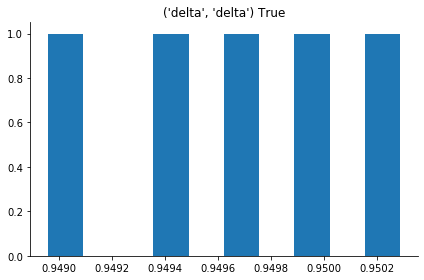

                                     bootstrap_0  bootstrap_1  bootstrap_2  \
category       name                                                          
delta          delta                    0.949999     0.948957     0.949622   
wage_fishing   exp_fishing              0.070000     0.070000     0.070000   
nonpec_fishing constant                -0.100000    -0.100000    -0.100000   
nonpec_hammock constant                 1.046000     1.046000     1.046000   
shocks_sdcorr  sd_fishing               0.010000     0.010000     0.010000   
               sd_hammock               0.010000     0.010000     0.010000   
               corr_hammock_fishing     0.000000     0.000000     0.000000   

                                     bootstrap_3  bootstrap_4  
category       name                                            
delta          delta                    0.950286     0.949389  
wage_fishing   exp_fishing              0.070000     0.070000  
nonpec_fishing constant                -0

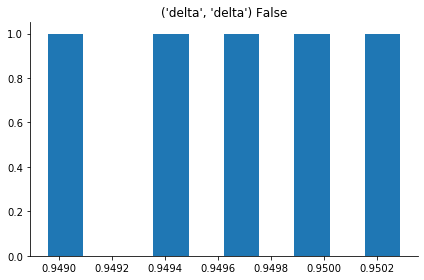

                                     bootstrap_0  bootstrap_1  bootstrap_2  \
category       name                                                          
delta          delta                    0.950000     0.950000     0.950000   
wage_fishing   exp_fishing              0.070000     0.070000     0.070000   
nonpec_fishing constant                -0.100000    -0.100000    -0.100000   
nonpec_hammock constant                 1.046000     1.046000     1.046000   
shocks_sdcorr  sd_fishing               0.010000     0.010000     0.010000   
               sd_hammock               0.010000     0.010000     0.010000   
               corr_hammock_fishing     0.131734     0.061543     0.118048   

                                     bootstrap_3  bootstrap_4  
category       name                                            
delta          delta                    0.950000     0.950000  
wage_fishing   exp_fishing              0.070000     0.070000  
nonpec_fishing constant                -0

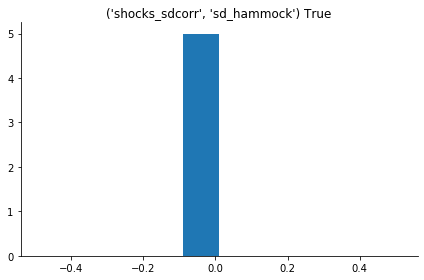

                                     bootstrap_0  bootstrap_1  bootstrap_2  \
category       name                                                          
delta          delta                    0.950000     0.950000     0.950000   
wage_fishing   exp_fishing              0.070000     0.070000     0.070000   
nonpec_fishing constant                -0.100000    -0.100000    -0.100000   
nonpec_hammock constant                 1.046000     1.046000     1.046000   
shocks_sdcorr  sd_fishing               0.010000     0.010000     0.010000   
               sd_hammock               0.010000     0.010000     0.010000   
               corr_hammock_fishing     0.131734     0.061543     0.118048   

                                     bootstrap_3  bootstrap_4  
category       name                                            
delta          delta                    0.950000     0.950000  
wage_fishing   exp_fishing              0.070000     0.070000  
nonpec_fishing constant                -0

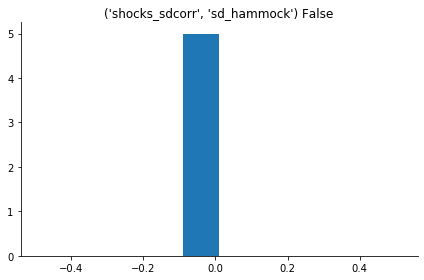

In [281]:
num_boots = 5
    
for i, index in enumerate([("delta", "delta"), ("shocks_sdcorr", "sd_hammock")]):
    
    constr = constr_base.copy()

    # We fix the discount factor and free "corr_hammock_fishing"
    if i == 1:
        constr.pop(2)
        constr.append({'loc': "delta", "type": "fixed"})
    
    for is_perturb in [True, False]:

        if True:
            boot_params = run_bootstrap(df, params_base, options_base, constr, num_boots, is_perturb)
        else:
            boot_params = pd.read_pickle("bootstrap.robinson.pkl")

        print(boot_params)
        fig, ax = plt.subplots()

        ax.hist(boot_params.loc[index, :])
        ax.set_title(f"{index} {is_perturb}")

        plt.show()
        


## Likelihood-based intervals

In [134]:
from scipy.optimize import root_scalar

# I just take the first ones, even thought these are not the estimates


def find_root(delta):
    
    params_eval = params_base.copy()
    params_eval.loc[('delta', "delta")] = delta

    likl_ratio = np.exp(crit_func(params_eval)- crit_func(params_base))    
    
    return likl_ratio
    
def root_wrapper(delta, alpha):
    
    assert alpha in [0.05, 0.001]
    
    if alpha == 0.05:
        crit_val = 0.15
    else:
        crit_val = 0.04
    
    return find_root(delta) - crit_val

In [160]:
rslt = list()
for bound in [-0.2, 0.2]:
    root = root_scalar(root_wrapper, method="bisect", bracket=[0.95, 0.95 + bound], args=(0.05,)).root
    rslt.append(root)
"{:5.3f} / {:5.3f}".format(*rslt)

'0.915 / 0.986'

## Large-sample approximation

In [136]:
fdd = nd.Derivative(p_wrapper_crit_func, n=2)([mle_est]) 

/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


In [159]:
rslt = list()
rslt.append(0.95 - 1 / 1000 * np.sqrt(-fdd))
rslt.append(0.95 + 1 / 1000 * np.sqrt(-fdd))
"{:5.3f} / {:5.3f}".format(*rslt)

'0.903 / 0.997'

### Smoothing parameter

There are many numerical tuning parameters involved in the construction of the likelihood function (e.g. numerical integration, smoothing parameter). We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$.

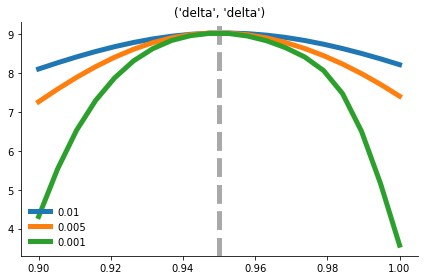

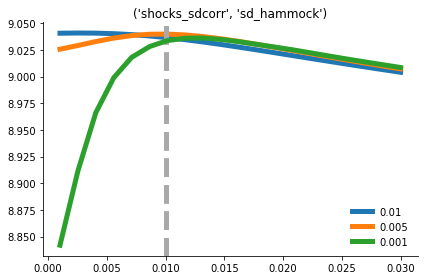

In [166]:
for index in [("delta", "delta"), ("shocks_sdcorr", "sd_hammock")]:
    fig, ax = plt.subplots()

    for tau in [0.01, 0.005, 0.001]:

        options = options_base.copy()
        options["estimation_tau"] = tau

        crit_func = rp.get_crit_func(params_base, options, df)

        upper, lower = params_base.loc[index][["upper", "lower"]]

        grid = np.linspace(lower, upper, 20)

        fvals = list()
        for value in grid:
            params = params_base.copy()
            params.loc[index, "value"] = value
            fvals.append(crit_func(params))

        ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--")

        ax.plot(grid, fvals, label=f"{tau}")
        ax.set_title(index)
        ax.legend()

    plt.show()